In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

import yaml

from icu_mortality_prediction import DATA_DIR


In [2]:
from icu_mortality_prediction.src.features import ptnt_demog
from icu_mortality_prediction.src.utils import data_utils
from icu_mortality_prediction.src.utils import feature_selection

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using postgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis according to the Angus criteria (Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file PTNT_DEMOG_FIRST24.csv. The data was read into a pandas dataframe lab_events.

## IMPORTING DATA

In [3]:
# patient demographic data includes diagnoses and icd9 codes for each patient and each icustay
demographics_filename = 'PTNT_DEMOG_FIRST24.csv'
demographics_filepath = os.path.join(DATA_DIR, 'interim',demographics_filename)
ptnt_demog_data = pd.read_csv(demographics_filepath, index_col = 'icustay_id')
ptnt_demog_data = ptnt_demog_data.head(10000)
ptnt_demog_data2 = ptnt_demog_data[~ptnt_demog_data.index.duplicated(keep='first')].copy()
# ptnt_demog_data2.drop(['subject_id', 'deathtime', 'hadm_id'], inplace = True, axis = 1)
# cols = list(ptnt_demog_data2.columns)
# cols.insert(0, cols.pop(cols.index('hospital_expire_flag')))
# ptnt_demog_data2 = ptnt_demog_data2[cols]
print("imported")


imported


In [4]:
demographics_filepath

'/Users/robertbeetel/Workspace/personal_projects/icu_data_exploration/icu_mortality_prediction/icu_mortality_prediction/data/interim/PTNT_DEMOG_FIRST24.csv'

In [5]:
ptnt_demog_data.columns

Index(['hadm_id', 'subject_id', 'first_careunit', 'gender', 'marital_status',
       'ethnicity', 'insurance', 'admission_type', 'admittime', 'dischtime',
       'intime', 'outtime', 'deathtime', 'dob', 'hospital_expire_flag',
       'icd9_code', 'icd9_code.1', 'short_title', 'seq_num'],
      dtype='object')

In [6]:
# drop patient and hospital stay ID's

ptnt_demog_data2.drop(['hadm_id', 'subject_id', 'seq_num'], axis=1, inplace=True)

In [7]:
date_time_cols = ['dob', 'admittime', 'dischtime', 'intime', 'outtime', 'deathtime']
ptnt_demog_data2 = data_utils.cast_dates_and_times(ptnt_demog_data2, date_time_cols)

converting dob
converting admittime
converting dischtime
converting intime
converting outtime
converting deathtime


In [8]:
#print(ptnt_demog.columns)
print("calling calculate_durations")
ptnt_demog_data2 = ptnt_demog.calculate_age_icu_and_hospital_stay_durations(ptnt_demog_data2)
#print "ptnt_demog2 out of function"

calling calculate_durations
Calculating ages, duration of stays


In [9]:
# replace age greater than 100yrs
ptnt_demog_data2 = ptnt_demog.remove_age_greater_than_100yrs(ptnt_demog_data2)


In [10]:
print("calling create_diagnoses_defs")
diagnoses_bm_list, diagnoses = ptnt_demog.create_diagnoses_defs(ptnt_demog_data2)
#print(diagnoses_bm)
#print(diagnoses.head())

calling create_diagnoses_defs
creating diagnoses definitions
creating diagnoses definitions
map created


In [11]:
print("calling create_diagnoses_df")
diagnoses2 = ptnt_demog.create_diagnoses_df(ptnt_demog_data2, diagnoses_bm_list, diagnoses)
#print(ptnt_demog_data.head())


calling create_diagnoses_df


In [12]:
# Drop no longer useful diagnosis code columns from demographics table
diagnosis_cols = [
                    'icd9_code', 
                    'icd9_code.1', 
                    'short_title'
                    ]
# Drop diagnosis columns
ptnt_demog_data2.drop(diagnosis_cols, axis=1, inplace=True)


In [13]:
ptnt_demog_data2.drop(['icu_stay_duration', 'hosp_stay_duration'], 
                       axis=1, inplace=True)


In [14]:
columns_by_data_type_dict = data_utils.group_column_names_by_data_type(ptnt_demog_data2)

In [15]:
columns_by_data_type_dict

{'float64_cols': ['age'],
 'categorical_cols': ['first_careunit',
  'gender',
  'marital_status',
  'ethnicity',
  'insurance',
  'admission_type'],
 'bool_cols': [],
 'int64_cols': ['hospital_expire_flag'],
 'datetime64[ns]': ['admittime',
  'dischtime',
  'intime',
  'outtime',
  'deathtime',
  'dob']}

In [16]:
# Drop no longer useful date-times from demographics table

ptnt_demog_data2.drop(columns_by_data_type_dict['datetime64[ns]'],
                                                axis=1, inplace=True)



In [17]:
print("Calling continuous to categorical conversion")
ptnt_demog_data2 = data_utils.continuous_to_categorical(ptnt_demog_data2, columns_by_data_type_dict)
#print(ptnt_demog_data.head())

Calling continuous to categorical conversion
               age
count  1562.000000
mean     63.442382
std      16.348764
min      18.000000
25%      53.000000
50%      67.000000
75%      77.000000
max      89.000000


### RE-ORDER COLUMNS

In [18]:
cols = list(ptnt_demog_data2.columns)
cols.insert(0, cols.pop(cols.index('hospital_expire_flag')))
ptnt_demog_data2 = ptnt_demog_data2[cols]
ptnt_demog_data2.columns

Index(['hospital_expire_flag', 'first_careunit', 'gender', 'marital_status',
       'ethnicity', 'insurance', 'admission_type', 'age'],
      dtype='object')

In [19]:
print("Calling categorical to dummy variables")
ptnt_demog_feature_cols = ptnt_demog_data2.columns[1:]
ptnt_demog_features_one_hot_df = data_utils.one_hot_encode_categorical_features(ptnt_demog_data2, ptnt_demog_feature_cols)


Calling categorical to dummy variables


In [20]:
ptnt_demog_features_one_hot_df = ptnt_demog_features_one_hot_df.merge(diagnoses2, left_index = True, right_index = True, 
                           how = 'left')

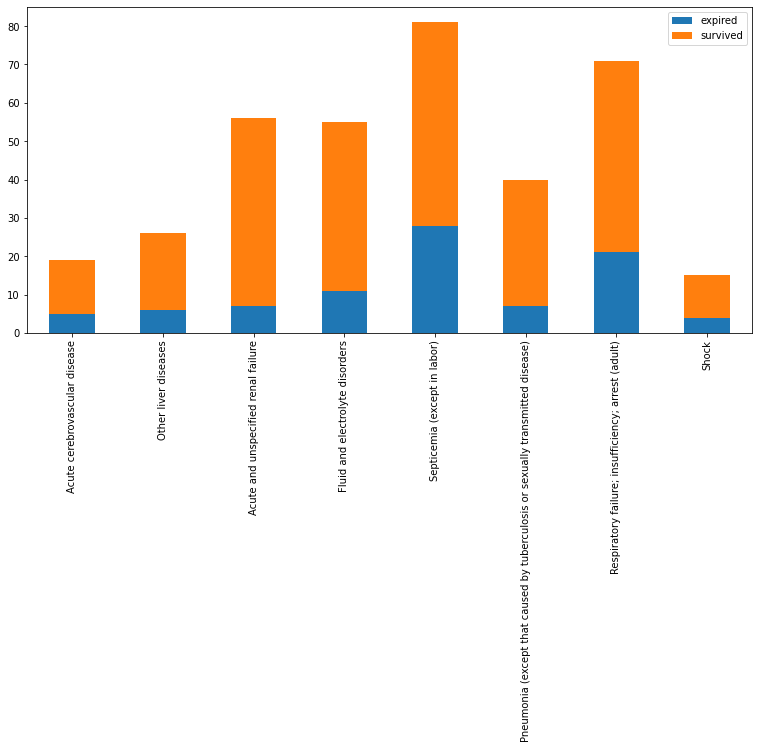

In [22]:


diags = [
 'hospital_expire_flag',
 'Acute cerebrovascular disease',
 'Other liver diseases',
 'Acute and unspecified renal failure',
 'Fluid and electrolyte disorders',
 'Septicemia (except in labor)',
 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
 'Respiratory failure; insufficiency; arrest (adult)',
 'Shock'
 ]


expired_diag_series = diags_df[diags_df.columns[1:]][diags_df['hospital_expire_flag']==1].sum()
expired_diag_series.name = 'expired'

survived_diag_series = diags_df[diags_df.columns[1:]][diags_df['hospital_expire_flag']==0].sum()
survived_diag_series.name = 'survived'

diagnoses_by_survival_pd = pd.concat(
    [
        expired_diag_series,
        survived_diag_series
    ], 
    axis=1
)

diagnoses_by_survival_pd.plot.bar(
        label= 'Survival', 
        stacked=True, 
        figsize=(13,6)
)

In [22]:
ptnt_demog_features_one_hot_df.shape

(1618, 68)

In [24]:
feature_selection_parameters_dict = {
                                'k': 'all',
                                'p_val': 0.2,
                                'scorer': 'chi2'
}

In [25]:
k_best_features_ranked_by_p_value = feature_selection.select_k_best_features(
                                        ptnt_demog_features_one_hot_df, 
                                        feature_selection_parameters_dict)

Selecting all best features 



In [27]:
k_best_features_ranked_by_p_value

Septicemia (except in labor)                          4.259116e-08
first_careunit_CSRU                                   1.048401e-06
admission_type_ELECTIVE                               2.759577e-06
age_Q3                                                2.735699e-05
Respiratory failure; insufficiency; arrest (adult)    9.388291e-05
                                                          ...     
marital_status_MARRIED                                8.779502e-01
admission_type_URGENT                                 8.816750e-01
Congestive heart failure; nonhypertensive             9.527329e-01
Other lower respiratory disease                                NaN
Other upper respiratory disease                                NaN
Name: select_best p-values, Length: 67, dtype: float64

In [54]:
# best_features_selected_by_p_value = feature_selection.select_best_features_by_p_value(
#                                         ptnt_demog_features_one_hot_df, 
#                                         feature_selection_parameters_dict)

Selecting features with p-values < 0.2

Filtering features to include only those with p-val < 0.2.
resulting in 25 features


In [29]:
# ptnt_demog_features_one_hot_df[best_features_selected_by_p_value.index].head()


In [31]:
k_best_features_ranked_by_p_value.index

Index(['Septicemia (except in labor)', 'first_careunit_CSRU',
       'admission_type_ELECTIVE', 'age_Q3',
       'Respiratory failure; insufficiency; arrest (adult)',
       'Coronary atherosclerosis and other heart disease',
       'first_careunit_MICU', 'age_Q0', 'insurance_Private',
       'insurance_Medicare', 'ethnicity_UNKNOWN/NOT SPECIFIED', 'age_Q1',
       'admission_type_EMERGENCY', 'marital_status_UNKNOWN (DEFAULT)',
       'insurance_Government', 'marital_status_DIVORCED', 'insurance_Self Pay',
       'marital_status_SINGLE', 'first_careunit_TSICU',
       'Complications of surgical procedures or medical care',
       'Acute cerebrovascular disease', 'Shock',
       'Diabetes mellitus with complications', 'Other liver diseases',
       'Fluid and electrolyte disorders', 'marital_status_WIDOWED', 'age_Q2',
       'Chronic obstructive pulmonary disease and bronchiectasis',
       'insurance_Medicaid', 'first_careunit_CCU', 'ethnicity_BLACK/AFRICAN',
       'Pleurisy; pneumoth

In [32]:
ptnt_demog_features_filename = 'Ptnt_Demog_Features.csv'
features_dirname = 'features'
ptnt_demog_features_filepath = os.path.join(DATA_DIR, 'processed',features_dirname,ptnt_demog_features_filename)

ptnt_demog_features_one_hot_df[k_best_features_ranked_by_p_value.index].to_csv(
                        ptnt_demog_features_filepath)

In [33]:
ptnt_demog_features_one_hot_df[k_best_features_ranked_by_p_value.index].head()

,Septicemia (except in labor),first_careunit_CSRU,admission_type_ELECTIVE,age_Q3,Respiratory failure; insufficiency; arrest (adult),Coronary atherosclerosis and other heart disease,first_careunit_MICU,age_Q0,insurance_Private,insurance_Medicare,...,Acute myocardial infarction,Diabetes mellitus without complication,Acute and unspecified renal failure,first_careunit_SICU,ethnicity_HISPANIC OR LATINO,marital_status_MARRIED,admission_type_URGENT,Congestive heart failure; nonhypertensive,Other lower respiratory disease,Other upper respiratory disease
icustay_id,,,,,,,,,,,,,,,,,,,,,
211552,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
294638,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
228232,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
220597,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
232669,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
